In [1]:
from gfrl.base.run_my_ppo2 import create_single_scenic_environment

In [2]:
network = "gfootball_impala_cnn"
#network = "impala_cnn"

#scenario = "../_scenarios/academy/3v1.scenic"
scenario = "../_scenarios/academy/pass_n_shoot.scenic"



#load_path = "/home/ubuntu/ScenicGFootBall/training/gfrl/_saved_models/3v1_5M/final_00610"
load_path = "/home/ubuntu/ScenicGFootBall/training/gfrl/_saved_models/pass_shoot_5M"
#load_path = "/home/ubuntu/ScenicGFootBall/training/gfrl/_saved_models/pass_n_shoot/00100"

#load_path = "/home/ubuntu/ScenicGFootBall/training/gfrl/_saved_models/pns"

In [3]:
#from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv
vec_env = DummyVecEnv([lambda _i=i: \
                        create_single_scenic_environment(_i,scenario) for i in
                        range(1)])

/home/ubuntu/.local/lib/python3.7/site-packages/scenic/core/errors.py:160: UserWarning: unable to install sys.excepthook to format Scenic backtraces
  warnings.warn('unable to install sys.excepthook to format Scenic backtraces')


Scenic Environment:  ../_scenarios/academy/pass_n_shoot.scenic
pygame 2.0.1 (SDL 2.0.14, Python 3.7.10)
Hello from the pygame community. https://www.pygame.org/contribute.html
Logging to /tmp/openai-2021-04-23-06-55-48-480226


In [4]:
import tensorflow.compat.v1 as tf
import multiprocessing
#import tensorflow as tf

ncpu = multiprocessing.cpu_count()
config = tf.ConfigProto(allow_soft_placement=True,
                        intra_op_parallelism_threads=ncpu,
                        inter_op_parallelism_threads=ncpu)
config.gpu_options.allow_growth = True
tf.Session(config=config).__enter__()


In [5]:
from gfrl.common.mybase import ppo2
model = ppo2.learn(
    network=network,
    total_timesteps=0,
    env=vec_env,
    nsteps=512,
    load_path=load_path
    )






Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






In [6]:
from gfrl.dm.my_runner import MyTrajRunner

from baselines.common.vec_env.dummy_vec_env import DummyVecEnv
vec_env = DummyVecEnv([lambda _i=i: \
                        create_single_scenic_environment(_i,scenario) for i in
                        range(1)])

runner = MyTrajRunner(env=vec_env, model=model, nsteps=512, num_episodes=10)
mb_obs, mb_rewards, mb_dones, mb_actions, mb_values, mb_neglogpacs, mb_states, epinfos, mb_gt = runner.run()
print(mb_obs.shape, mb_dones.shape)


Scenic Environment:  ../_scenarios/academy/pass_n_shoot.scenic
in run
(328, 72, 96, 16) (328,)


In [7]:
import numpy as np
np.sum(mb_rewards), np.sum(mb_dones), 

(7.0, 9)

In [8]:
gt_trajs = []
rew_trajs = []

gts, rews = [], []

for i in range(mb_obs.shape[0]):
    
    #states.append(mb_obs[i])
    gts.append(mb_gt[i].copy())
    rews.append(mb_rewards[i].copy())
    
    if mb_dones[i] or i==mb_obs.shape[0]-1:
        gt_trajs.append(gts)
        rew_trajs.append(rews)
        gts, rews = [], []

In [9]:
#np.sum([len(arr[0]) for arr in trajs])

In [10]:
len(gt_trajs[0])

32

In [11]:
gt_trajs[0][0]

[{'left_team_yellow_card': array([False, False, False]),
  'ball_owned_team': -1,
  'left_team_active': array([ True,  True,  True]),
  'right_team': array([[ 1.0009191 ,  0.        ],
         [ 0.75827205, -0.30488038]]),
  'ball_owned_player': -1,
  'left_team_tired_factor': array([0., 0., 0.]),
  'ball': array([ 0.69999999, -0.28      ,  0.11061639]),
  'right_team_tired_factor': array([0., 0.]),
  'ball_direction': array([ 0.        , -0.        ,  0.00616395]),
  'right_team_roles': array([0, 1]),
  'left_team': array([[-1.0009191 , -0.        ],
         [ 0.70772058, -0.        ],
         [ 0.70772058, -0.30488038]]),
  'game_mode': 0,
  'right_team_yellow_card': array([False, False]),
  'right_team_direction': array([[-0.,  0.],
         [-0.,  0.]]),
  'left_team_direction': array([[ 0., -0.],
         [ 0., -0.],
         [ 0., -0.]]),
  'left_team_roles': array([0, 1, 1]),
  'score': [0, 0],
  'steps_left': 401,
  'ball_rotation': array([ 0., -0.,  0.]),
  'right_team_acti

In [12]:
def gt_reader(gt):
    left_team = gt[0]["left_team"].copy()*100
    left_team[:,0] *=  1
    left_team[:,1] *= -1
    
    right_team = gt[0]["right_team"].copy()*100
    right_team[:,0] *=  1
    right_team[:,1] *= -1
    
    ball = gt[0]["ball"].copy()[0:2]*100
    ball[1] *= -1
    
    return left_team, right_team, ball
    
left_team, right_team, ball = gt_reader(gt_trajs[0][0])
my_points = left_team
print(left_team)
print(right_team)
print(ball)

[[-100.09191036    0.        ]
 [  70.77205777    0.        ]
 [  70.77205777   30.48803806]]
[[100.09191036  -0.        ]
 [ 75.82720518  30.48803806]]
[69.99999881 28.00000012]


In [13]:
#len(gt_trajs[0])

trajectory = gt_trajs[0]

traj_data = []
gt = trajectory[0]
#for i, gt in enumerate(trajectory):
    
left_team, right_team, ball = gt_reader(gt)

lx = left_team[:,0]
ly = left_team[:,1]
lc = "green"

rx = right_team[:,0]
ry = right_team[:,1]
rc = "red"



print()
    
#    if i==0: break

<IPython.core.display.Javascript object>


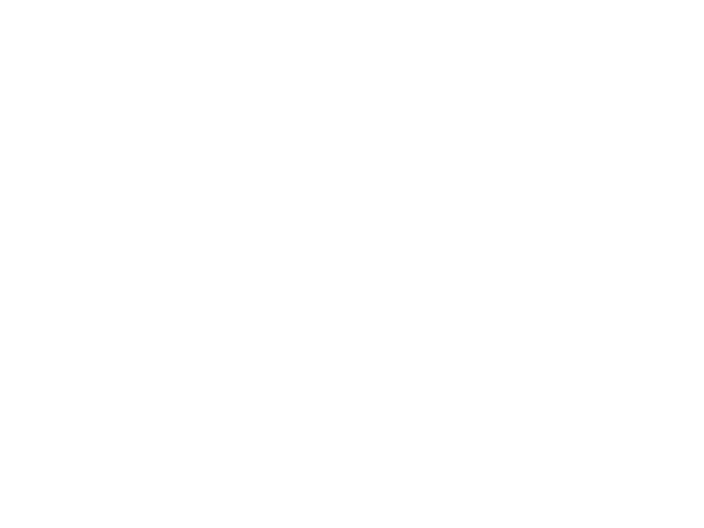

In [14]:
%matplotlib nbagg
import matplotlib.pyplot as plt
pcoll1 = plt.scatter([],[],color=lc)
pcoll1.set_offsets(left_team)
plt.scatter(rx,ry,color=rc)
plt.scatter([ball[0]],[ball[1]], color="black")


plt.xlim(-105, 105)
plt.ylim(-45, 45)
plt.show()

In [15]:
total_rews = [np.sum(rt) for rt in rew_trajs]

In [16]:
print(total_rews)

[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]


In [26]:
trajectory = gt_trajs[0]

traj_data = []


mp = []
op = []
bp = []

for i, gt in enumerate(trajectory):
    
    left_team, right_team, ball = gt_reader(gt)

    mp.append(left_team)
    op.append(right_team)
    bp.append([ball])
    




<IPython.core.display.Javascript object>


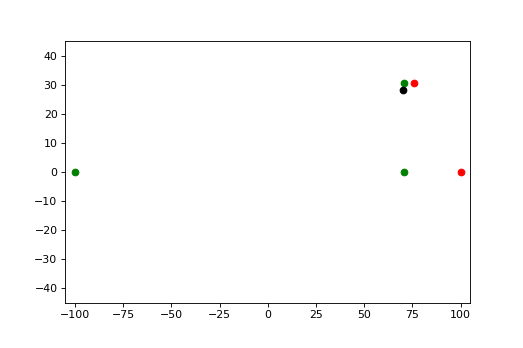

(-45.0, 45.0)

In [27]:
%matplotlib nbagg
pcollm = plt.scatter([],[],color="green")
pcollo = plt.scatter([],[],color="red")
pcollb = plt.scatter([],[],color="black")

pcollm.set_offsets(mp[0])
pcollo.set_offsets(op[0])
pcollb.set_offsets(bp[0])



plt.xlim(-105, 105)
plt.ylim(-45, 45)
#plt.show()


In [28]:
#https://salernoali.medium.com/making-an-animated-graph-with-matplotlib-seaborn-3f865fa8c16a
#https://stackoverflow.com/questions/46236902/redrawing-seaborn-figures-for-animations
#https://salernoali.medium.com/making-an-animated-graph-with-matplotlib-seaborn-3f865fa8c16a

<IPython.core.display.Javascript object>


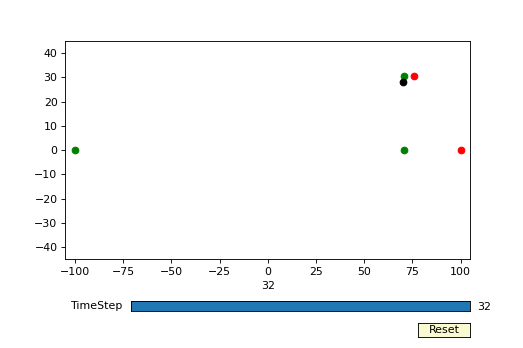

In [29]:
%matplotlib nbagg

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button


# The parametrized function to be plotted
def f(t, amplitude, frequency):
    return amplitude * np.sin(2 * np.pi * frequency * t)

t = np.linspace(0, 1, 1000)

# Define initial parameters
init_amplitude = 5
init_frequency = 3

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
#line, = plt.plot(t, f(t, init_amplitude, init_frequency), lw=2)
pcollm = plt.scatter([],[],color="green")
pcollo = plt.scatter([],[],color="red")
pcollb = plt.scatter([],[],color="black")

pcollm.set_offsets(mp[0])
pcollo.set_offsets(op[0])
pcollb.set_offsets(bp[0])
#plt.scatter(rx,ry,color=rc)
#plt.scatter([ball[0]],[ball[1]], color="black")


plt.xlim(-105, 105)
plt.ylim(-45, 45)


ax.set_xlabel('Timestep')

axcolor = 'lightgoldenrodyellow'
ax.margins(x=0)

# adjust the main plot to make room for the sliders
#plt.subplots_adjust(left=0.25, bottom=0.25)
plt.subplots_adjust( bottom=0.25)

# Make a horizontal slider to control the frequency.
axfreq = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
freq_slider = Slider(
    ax=axfreq,
    label='TimeStep',
    valmin=0,
    valmax=len(mp),
    valinit=0,
    valstep=1
)

# Make a vertically oriented slider to control the amplitude
"""
axamp = plt.axes([0.1, 0.25, 0.0225, 0.63], facecolor=axcolor)
amp_slider = Slider(
    ax=axamp,
    label="Amplitude",
    valmin=0,
    valmax=10,
    valinit=init_amplitude,
    orientation="vertical"
)
"""


# The function to be called anytime a slider's value changes
def update(val):
    #line.set_ydata(f(t, amp_slider.val, freq_slider.val))
    #print(val)
    ts = int(round(freq_slider.val))
    #print(ts)
    ax.set_xlabel(f"{ts}")
    pcollm.set_offsets(mp[ts])
    pcollo.set_offsets(op[ts])
    pcollb.set_offsets(bp[ts])
    fig.canvas.draw_idle()
    #plt.draw()


# register the update function with each slider
freq_slider.on_changed(update)
#amp_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    freq_slider.reset()
    #amp_slider.reset()
button.on_clicked(reset)

plt.show()


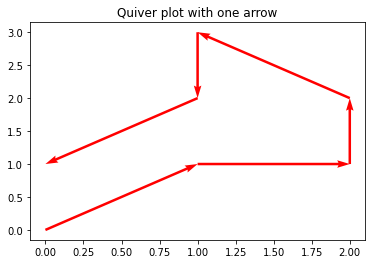

In [21]:
%matplotlib inline
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
  
    
points = np.array([[0,0], [1,1], [2,1], [2,2], [1,3], [1,2], [0,1]])
# Creating arrow
x_pos = points[:-1,0]
y_pos = points[:-1,1]
#x_direct = [points[i,0]-points[i-1,0] for i in range(1,points.shape[0]) ]
x_direct = points[1:, 0]-points[:-1, 0]
y_direct = points[1:, 1] - points[:-1, 1]

#y_direct = [points[i,1]-points[i-1,1] for i in range(1,points.shape[0]) ]

# Creating plot
fig, ax = plt.subplots()
ax.quiver(x_pos, y_pos, x_direct, y_direct, scale_units='xy', angles='xy', scale=1, color="red")
ax.set_title('Quiver plot with one arrow')

# Show plot
plt.show()

In [32]:
trajectory = gt_trajs[0]

traj_data = []


mp = []
op = []
bp = []

for i, gt in enumerate(trajectory):
    
    left_team, right_team, ball = gt_reader(gt)

    mp.append(left_team)
    op.append(right_team)
    bp.append([ball])

#mpn = np.array(mp)
#opn = np.array(op)
#bpn = np.array(bp)



In [45]:
#mpns = mpn[0:6,:,:]

array([[[-1.00091910e+02,  0.00000000e+00],
        [ 7.07720578e+01,  0.00000000e+00],
        [ 7.07720578e+01,  3.04880381e+01]],

       [[-1.00091910e+02,  0.00000000e+00],
        [ 7.07720578e+01,  0.00000000e+00],
        [ 7.07388639e+01,  3.03810596e+01]],

       [[-9.99963760e+01,  1.39371448e-02],
        [ 7.07438409e+01,  1.79757815e-02],
        [ 7.06498623e+01,  3.00942510e+01]],

       [[-9.95819211e+01,  5.72277699e-02],
        [ 7.04803228e+01,  1.93816517e-01],
        [ 7.05289364e+01,  2.97045618e+01]],

       [[-9.89938736e+01,  8.04059091e-02],
        [ 7.01133549e+01,  4.56567435e-01],
        [ 7.03867733e+01,  2.92465091e+01]],

       [[-9.82572734e+01,  8.34147912e-02],
        [ 6.96524918e+01,  8.00988171e-01],
        [ 7.03100920e+01,  2.88105637e+01]]])

In [80]:
#print(mpns.shape)
mpns_s = np.swapaxes(mpn[:-1,:,:], 0, 1)
print(mpns_s.shape)



(3, 31, 2)


In [127]:
def get_quiver_data(team_traj, c="green", exclude_pid=[]):
    pos_data = np.swapaxes(team_traj[:-1,:,:], 0, 1)
    xs = np.array([])
    ys = np.array([])
    dxs = np.array([])
    dys = np.array([])
    cs = []
    for pid in range(pos_data.shape[0]):
        if pid in exclude_pid: continue
        pos = pos_data[pid,:,:]
        x = pos[:-1,0]
        y = pos[:-1,1]
        dx = pos[1:, 0]-pos[:-1, 0]
        dy = pos[1:, 1] - pos[:-1, 1]

        #print(x.shape)
        xs = np.concatenate((xs, x), axis=0)
        ys = np.concatenate((ys, y), axis=0)
        dxs = np.concatenate((dxs, dx), axis=0)
        dys = np.concatenate((dys, dy), axis=0)
        cs.extend([c]*x.shape[0])
    
    return xs, ys, dxs, dys, cs

In [128]:
mxs, mys, mdxs, mdys, mcs = get_quiver_data(np.array(mp), c="green") #exclude_pid=[0]
oxs, oys, odxs, odys, ocs = get_quiver_data(np.array(op), c="red")


In [129]:
xs = np.concatenate((mxs, oxs), axis=0)
ys = np.concatenate((mys, oys), axis=0)
dxs = np.concatenate((mdxs, odxs), axis=0)
dys = np.concatenate((mdys, odys), axis=0)
cs = mcs+ocs

<IPython.core.display.Javascript object>


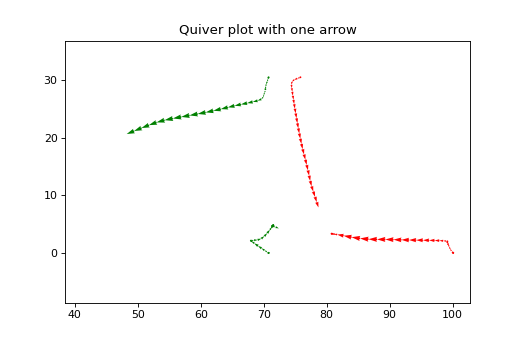

In [133]:
# Creating plot
fig, ax = plt.subplots()
plt.xlim(-105, 105)
plt.ylim(-45, 45)
ax.quiver(xs, ys, dxs, dys, scale_units='xy', angles='xy', scale=1, color=cs)
ax.set_title('Quiver plot with one arrow')

# Show plot
plt.show()

<IPython.core.display.Javascript object>


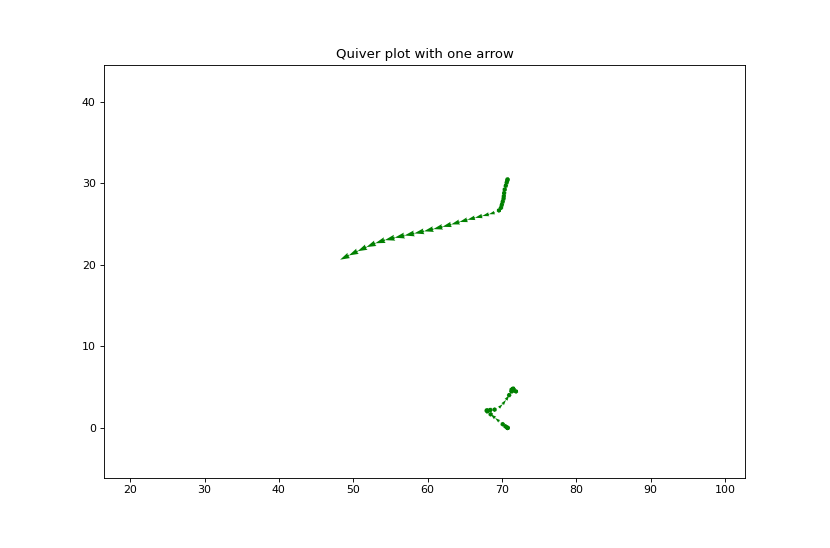

In [134]:
mxs, mys, mdxs, mdys, mcs = get_quiver_data(np.array(mp), c="green", exclude_pid=[0])
# Creating plot
fig, ax = plt.subplots()
plt.xlim(-105, 105)
plt.ylim(-45, 45)
ax.quiver(mxs, mys, mdxs, mdys, scale_units='xy', angles='xy', scale=1, color=mcs)
ax.set_title('Quiver plot with one arrow')

# Show plot
plt.show()